# Relevance Forward Propagation for SEN12MS

In [1]:
from datasets.sen12ms import SEN12MS, Normalize, ToTensor, bands_mean, bands_std, CLASS_NAMES;
from models.networks.resnet import ResNet50;
from models.network_mapper import to_relevance_representation, to_basic_representation;
from utils.Utils import input_mapping, set_seed
import matplotlib.pyplot as plt;
from matplotlib.gridspec import GridSpec
from torch.utils.data import DataLoader;
import seaborn as sns
import torchvision.transforms as transforms;
import os
from config.config import label_split_dir_cfg, data_dir_sen12mscr_cfg, data_dir_sen12ms_cfg, ckpt_path_resnet50_sen12ms_cfg

import torch;
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

/home/jakob/Documents/PhD/Projects/ModalityRelevanceScores_old/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


## Pretrained Model
| Variable | Options | Explanation |
| --- | --- | --- |
| ckpt_path | string | Path to model checkpoint|

In [2]:
ckpt_path = ckpt_path_resnet50_sen12ms_cfg

In [3]:
checkpoint = torch.load(ckpt_path, map_location="cpu")
model = ResNet50(n_inputs=12, num_classes=10)
model.load_state_dict(checkpoint["model_state_dict"]);

## Model Evaluation
#### Load Test Data
**Data Setup**
| Variable | Data Type | Explanation |
| --- | --- | --- |
| data_dir_clear | string | root path of SEN12MS |
| data_dir_cloudy | string | root path of SEN12MSCR |
| label_split_dir | string | path to label_split pickle file |


In [4]:
# Data Setup
data_dir_clear = data_dir_sen12ms_cfg
data_dir_cloudy = data_dir_sen12mscr_cfg
label_split_dir = label_split_dir_cfg

batch_size = 16
img_transform = transforms.Compose([ToTensor(),
                                     Normalize(bands_mean, 
                                               bands_std)])

### Setup Clear and Cloudy Data Set

In [8]:
set_seed(42)
test_data = SEN12MS(path_clear=data_dir_clear, 
                    path_cloudy=data_dir_cloudy,
                    ls_dir=label_split_dir,
                    img_transform=img_transform,
                    label_type="single_label",
                    subset="test",
                    use_cloudy=True,
                    cloud_frac=1,
                    use_s1=True,
                    use_s2=True)
  
test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=8)

path clear:  /media/jakob/Expansion/DataSets/SEN12MS
path cloudy:  /media/jakob/Expansion/DataSets/SEN12MSCR


[Load]: 100%|██████████| 18106/18106 [00:06<00:00, 2819.05it/s]


Loaded 18106 files with 12666 Cloudy versions!
loaded 18106 samples from the sen12ms subset test


# Example Visualization
| Variable | Options | Explanation |
| --- | --- | --- |
| num_examples | [num_rows, num_cols] | Number of rows and columns of example images |

In [9]:
# Visualization
num_examples = [5,5]
figsize = [15,15]
fontsize = 10

### Plot Examples Clear and Cloudy

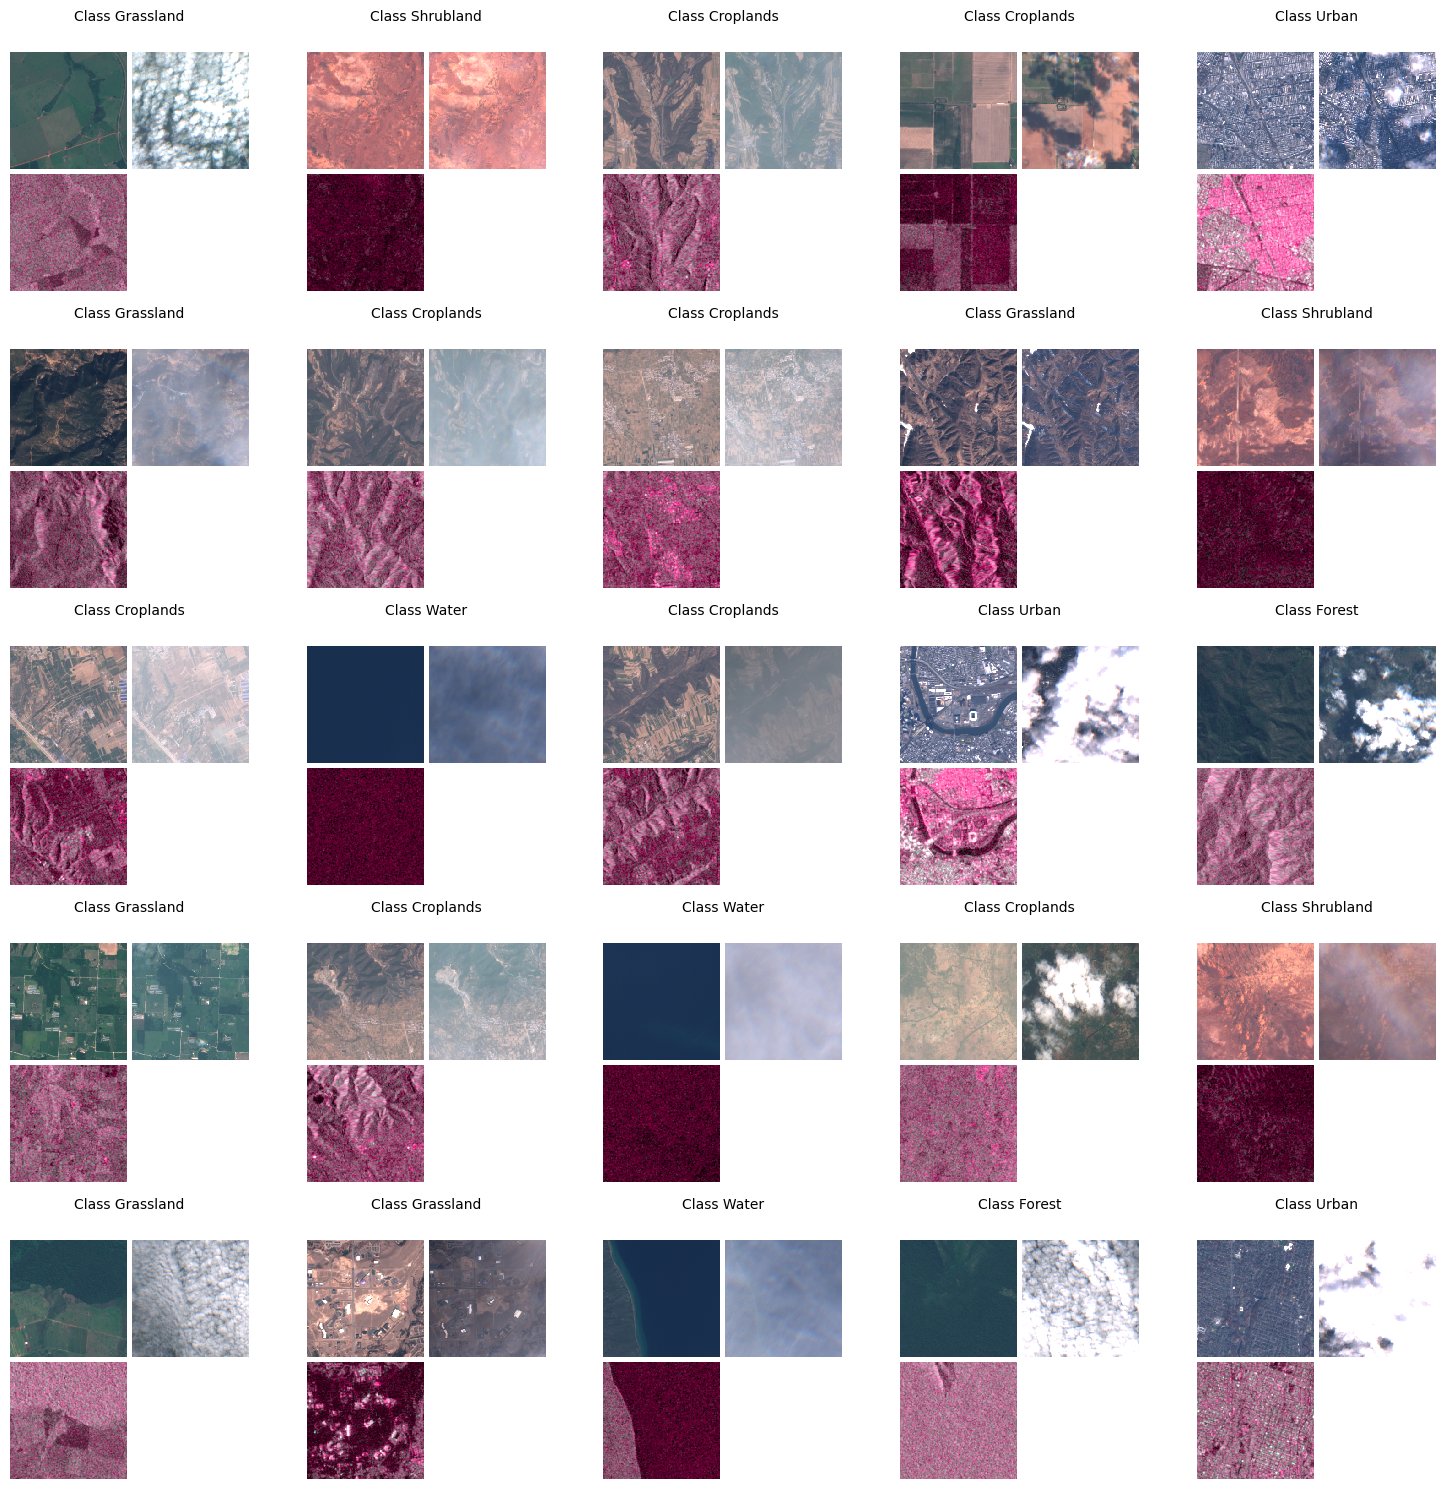

In [10]:
set_seed(42)
test_data.use_cloudy = True
fig, axs = plt.subplots(*num_examples, figsize=figsize)
test_data.plot_imgs(axs, num_examples, fontsize=fontsize)
fig.tight_layout()

# Model Evaluation

## Evaluate Clear Data Set

In [25]:
print("Evaluate Model with Clear Test Set")

criterion = torch.nn.CrossEntropyLoss()
# model = model.double().to(device)
model = model.to(device)
model.eval()

test_data.use_cloudy = False
test_data.cloud_frac = 0

with torch.no_grad():
  test_correct_count_clear = 0
  test_total_count_clear = 1e-20
  test_loss_sum_clear = 0
  test_pred_list_clear = []
  test_labels_list_clear = []
  test_id_list_clear = []
   
  for i, data in enumerate(test_data_loader):
    print(f"Eval Test Performance [{i+1} / {len(test_data_loader)}]    Acc {test_correct_count_clear/test_total_count_clear}", end="\r")
    label = data["label"].argmax(-1).to(device)
    # x = data["image"].double().to(device)
    x = data["image"].to(device)

    pred = model(x)

    test_pred_list_clear.append(pred.cpu())
    test_loss = criterion(pred, label)

    test_id_list_clear += data["id"]
    test_labels_list_clear.append(label.cpu())
    test_loss_sum_clear += test_loss.cpu().item()
    test_correct_count_clear += (label == pred.argmax(-1)).sum().cpu().item()
    test_total_count_clear += x.shape[-4]

  print(f"Eval Test Performance [{i+1} / {len(test_data_loader)}]     " +\
        f"Loss {test_loss_sum_clear/len(test_data_loader):.4f}    "+\
        f"Acc {test_correct_count_clear/test_total_count_clear:.4f}")
  
  test_pred_list_clear = torch.cat(test_pred_list_clear, 0)
  test_labels_list_clear = torch.cat(test_labels_list_clear, 0)


Evaluate Model with Clear Test Set
Eval Test Performance [1132 / 1132]     Loss 1.9439    Acc 0.6465


##### Save / Load Intermediate Results

In [28]:
# Run Cell to save
os.makedirs("./tmp_float", exist_ok=True)
torch.save({"test_loss_sum_clear": test_loss_sum_clear,
            "num_batches": len(test_data_loader),
            "test_correct_count_clear": test_correct_count_clear,
            "test_total_count_clear": test_total_count_clear,
            "test_pred_list_clear": test_pred_list_clear,
            "test_labels_list_clear": test_labels_list_clear,
            "test_id_list_clear": test_id_list_clear}, "./tmp_float/original_normal_clear.pth")

In [19]:
res_dict = torch.load("./tmp_float/original_normal_clear.pth")
test_loss_sum_clear = res_dict["test_loss_sum_clear"]
test_num_batches_clear = res_dict["num_batches"]
test_correct_count_clear = res_dict["test_correct_count_clear"]
test_total_count_clear = res_dict["test_total_count_clear"]
test_pred_list_clear = res_dict["test_pred_list_clear"]
test_labels_list_clear = res_dict["test_labels_list_clear"]
test_id_list_clear = res_dict["test_id_list_clear"]

## Evaluate Cloudy Data Set

In [29]:
print("Evaluate Model with Cloudy Test Set")

criterion = torch.nn.CrossEntropyLoss()
model = model.to(device)
# model = model.double().to(device)

model.eval()

test_data.use_cloudy = True
test_data.cloud_frac = 1.0

with torch.no_grad():
  test_correct_count_cloudy = 0
  test_total_count_cloudy = 1e-20
  test_loss_sum_cloudy = 0
  test_pred_list_cloudy = []
  test_labels_list_cloudy = []
  test_id_list_cloudy = []
  
  for i, data in enumerate(test_data_loader):
    print(f"Eval Test Performance [{i+1} / {len(test_data_loader)}]    Acc {test_correct_count_cloudy/test_total_count_cloudy}", end="\r")
    label = data["label"].argmax(-1).to(device)
    # x = data["image"].double().to(device)
    x = data["image"].to(device)

    pred = model(x)

    test_pred_list_cloudy.append(pred.cpu())
    test_loss = criterion(pred, label)

    test_id_list_cloudy += data["id"]
    test_labels_list_cloudy.append(label.cpu())
    test_loss_sum_cloudy += test_loss.cpu().item()
    test_correct_count_cloudy += (label == pred.argmax(-1)).sum().cpu().item()
    test_total_count_cloudy += x.shape[-4]

  print(f"Eval Test Performance [{i+1} / {len(test_data_loader)}]     " +\
        f"Loss {test_loss_sum_cloudy/len(test_data_loader):.4f}    "+\
        f"Acc {test_correct_count_cloudy/test_total_count_cloudy:.4f}")
  
  test_pred_list_cloudy = torch.cat(test_pred_list_cloudy, 0)


Evaluate Model with Cloudy Test Set


Eval Test Performance [1132 / 1132]     Loss 3.8009    Acc 0.4362


##### Save / Load Intermediate Results

In [ ]:
# Run Cell to save
os.makedirs("./tmp_float", exist_ok=True)
torch.save({"test_loss_sum_cloudy": test_loss_sum_cloudy,
            "num_batches": len(test_data_loader),
            "test_correct_count_cloudy": test_correct_count_cloudy,
            "test_total_count_cloudy": test_total_count_cloudy,
            "test_pred_list_cloudy": test_pred_list_cloudy,
            "test_labels_list_cloudy": test_labels_list_cloudy,
            "test_id_list_cloudy": test_id_list_cloudy}, "./tmp_float/original_normal_cloudy.pth")

In [18]:
# Run Cell to load
res_dict = torch.load("./tmp_float/original_normal_cloudy.pth")
test_loss_sum_cloudy = res_dict["test_loss_sum_cloudy"]
test_num_batches_cloudy = res_dict["num_batches"]
test_correct_count_cloudy = res_dict["test_correct_count_cloudy"]
test_total_count_cloudy = res_dict["test_total_count_cloudy"]
test_pred_list_cloudy = res_dict["test_pred_list_cloudy"]
test_labels_list_cloudy = res_dict["test_labels_list_cloudy"]
test_id_list_cloudy = res_dict["test_id_list_cloudy"]

## Evaluate Clear Data Set on RFP

In [11]:
print("Evaluate RFP Model with Clear Test Set")

criterion = torch.nn.CrossEntropyLoss()
# model = to_relevance_representation(model, verbose=0).double().to(device)
model = to_relevance_representation(model, verbose=0).to(device)
model.eval()

test_data.use_cloudy = False
test_data.cloud_frac = 0

with torch.no_grad():
  rfp_test_correct_count_clear = 0
  rfp_test_total_count_clear = 1e-20
  rfp_test_loss_sum_clear = 0
  rfp_test_pred_list_clear = []
  rfp_test_labels_list_clear = []
  rfp_test_id_list_clear = []

  for i, data in enumerate(test_data_loader):
    print(f"Eval Test Performance [{i+1} / {len(test_data_loader)}]    Acc {rfp_test_correct_count_clear/rfp_test_total_count_clear}", end="\r")
    label = data["label"].argmax(-1).to(device)

    x1, x2 = data["image"].split([10,2], dim=-3)
    x1, x2 = input_mapping(x1, x2)
    # x = torch.cat([x1,x2], -3).double().to(device=device)
    x = torch.cat([x1,x2], -3).to(device=device)

    pred = model(x)

    rfp_test_pred_list_clear.append(pred.cpu())
    test_loss = criterion(pred.sum(0), label)
    rfp_test_labels_list_clear.append(label.cpu())
    rfp_test_id_list_clear += data["id"]
    
    rfp_test_loss_sum_clear += test_loss.cpu().item()
    rfp_test_correct_count_clear += (label == pred.sum(0).argmax(-1)).sum().cpu().item()
    rfp_test_total_count_clear += x.shape[-4]

  print(f"Eval Test Performance [{i+1} / {len(test_data_loader)}]     " +\
        f"Loss {rfp_test_loss_sum_clear/len(test_data_loader):.4f}    "+\
        f"Acc {rfp_test_correct_count_clear/rfp_test_total_count_clear:.4f}")
  
  rfp_test_pred_list_clear = torch.cat(rfp_test_pred_list_clear, 1)
  rfp_test_labels_list_clear = torch.cat(rfp_test_labels_list_clear, 0)
model = to_basic_representation(model, verbose=0)

Evaluate RFP Model with Clear Test Set
Applied monkey patches for relevance forward propagation.
Eval Test Performance [1132 / 1132]     Loss 1.9439    Acc 0.6466
Removed all monkey patches for contribution propagation.


#### Save / Load Intermediate Results

In [12]:
# Run Cell to save
os.makedirs("./tmp_float", exist_ok=True)
torch.save({"rfp_test_loss_sum_clear": rfp_test_loss_sum_clear,
            "num_batches": len(test_data_loader),
            "rfp_test_correct_count_clear": rfp_test_correct_count_clear,
            "rfp_test_total_count_clear": rfp_test_total_count_clear,
            "rfp_test_pred_list_clear": rfp_test_pred_list_clear,
            "rfp_test_labels_list_clear": rfp_test_labels_list_clear,
            "rfp_test_id_list_clear": rfp_test_id_list_clear}, "./tmp_float/rfp_clear.pth")

In [30]:
# Run Cell to load
res_dict = torch.load("./tmp_double/rfp_clear.pth")
print(res_dict.keys())
rfp_test_loss_sum_clear = res_dict["rfp_test_loss_sum_clear"]
rfp_test_num_batches_clear = res_dict["num_batches"]
rfp_test_correct_count_clear = res_dict["rfp_test_correct_count_clear"]
rfp_test_total_count_clear = res_dict["rfp_test_total_count_clear"]
rfp_test_pred_list_clear = res_dict["rfp_test_pred_list_clear"]
rfp_test_labels_list_clear = res_dict["rfp_test_labels_list_clear"]
rfp_test_id_list_clear = res_dict["rfp_test_id_list_clear"]

dict_keys(['rfp_test_loss_sum_clear', 'num_batches', 'rfp_test_correct_count_clear', 'rfp_test_total_count_clear', 'rfp_test_pred_list_clear', 'rfp_test_labels_list_clear', 'rfp_test_id_list_clear'])


## Evaluate Cloudy Data Set on RFP

In [13]:
print("Evaluate RFP Model with Cloudy Test Set")

criterion = torch.nn.CrossEntropyLoss()
# model = to_relevance_representation(model, verbose=0).double().to(device)
model = to_relevance_representation(model, verbose=0).to(device)
model.eval()

test_data.use_cloudy = True
test_data.cloud_frac = 1

with torch.no_grad():
  rfp_test_correct_count_cloudy = 0
  rfp_test_total_count_cloudy = 1e-20
  rfp_test_loss_sum_cloudy = 0
  rfp_test_pred_list_cloudy = []
  rfp_test_labels_list_cloudy = []
  rfp_test_id_list_cloudy = []
  
  for i, data in enumerate(test_data_loader):
    print(f"Eval Test Performance [{i+1} / {len(test_data_loader)}]    Acc {rfp_test_correct_count_cloudy/rfp_test_total_count_cloudy}", end="\r")
    label = data["label"].argmax(-1).to(device)
    #x = data["image"].double().to(device)

    # x1, x2 = data["image"].double().split([10,2], dim=-3)
    x1, x2 = data["image"].split([10,2], dim=-3)
    x1, x2 = input_mapping(x1, x2)
    x = torch.cat([x1,x2], -3).to(device=device)

    pred = model(x)

    rfp_test_pred_list_cloudy.append(pred.cpu())
    test_loss = criterion(pred.sum(0), label)
    rfp_test_labels_list_cloudy.append(label.cpu())
    rfp_test_id_list_cloudy += data["id"]

    rfp_test_loss_sum_cloudy += test_loss.cpu().item()
    rfp_test_correct_count_cloudy += (label == pred.sum(0).argmax(-1)).sum().cpu().item()
    rfp_test_total_count_cloudy += x.shape[-4]

  print(f"Eval Test Performance [{i+1} / {len(test_data_loader)}]     " +\
        f"Loss {rfp_test_loss_sum_cloudy/len(test_data_loader):.4f}    "+\
        f"Acc {rfp_test_correct_count_cloudy/rfp_test_total_count_cloudy:.4f}")
  
  rfp_test_pred_list_cloudy = torch.cat(rfp_test_pred_list_cloudy, 1)
  rfp_test_labels_list_cloudy = torch.cat(rfp_test_labels_list_cloudy, 0)

model = to_basic_representation(model, verbose=0)

Evaluate RFP Model with Cloudy Test Set
Applied monkey patches for relevance forward propagation.
Eval Test Performance [1132 / 1132]     Loss 3.8007    Acc 0.4364
Removed all monkey patches for contribution propagation.


#### Save / Load Intermediate Results

In [22]:
# Run Cell to save
os.makedirs("./tmp_float", exist_ok=True)
torch.save({"rfp_test_loss_sum_cloudy": rfp_test_loss_sum_cloudy,
            "num_batches": len(test_data_loader),
            "rfp_test_correct_count_cloudy": rfp_test_correct_count_cloudy,
            "rfp_test_total_count_cloudy": rfp_test_total_count_cloudy,
            "rfp_test_pred_list_cloudy": rfp_test_pred_list_cloudy,
            "rfp_test_labels_list_cloudy": rfp_test_labels_list_cloudy,
            "rfp_test_id_list_cloudy": rfp_test_id_list_cloudy}, "./tmp_float/rfp_cloudy.pth")

In [29]:
# Run Cell to load
res_dict = torch.load("./tmp_double/rfp_cloudy.pth")
rfp_test_loss_sum_cloudy = res_dict["rfp_test_loss_sum_cloudy"]
rfp_test_num_batches_cloudy = res_dict["num_batches"]
rfp_test_correct_count_cloudy = res_dict["rfp_test_correct_count_cloudy"]
rfp_test_total_count_cloudy = res_dict["rfp_test_total_count_cloudy"]
rfp_test_pred_list_cloudy = res_dict["rfp_test_pred_list_cloudy"]
rfp_test_labels_list_cloudy = res_dict["rfp_test_labels_list_cloudy"]
rfp_test_id_list_cloudy = res_dict["rfp_test_id_list_cloudy"]

### Similarity Evaluation between RFP and Basic Propagation

In [25]:
print("Similarity Evaluation RFP and Basic Model")
print()
print("Output shapes")
print(f"    Basic Model:   Test Clear {test_pred_list_clear.shape}   Test Cloudy {test_pred_list_cloudy.shape}")
print(f"      RFP Model:   Test Clear {rfp_test_pred_list_clear.shape}   Test Cloudy {rfp_test_pred_list_cloudy.shape}")
print(f"Loss:")
print(f"    Basic Model:   Test Clear {test_loss_sum_clear/test_num_batches_clear:.6f}   Test Cloudy {test_loss_sum_cloudy/test_num_batches_cloudy:.6f}")
print(f"      RFP Model:   Test Clear {rfp_test_loss_sum_clear/rfp_test_num_batches_clear:.6f}   Test Cloudy {rfp_test_loss_sum_cloudy/rfp_test_num_batches_cloudy:.6f}")
print(f"          Delta:   Test Clear {(rfp_test_loss_sum_clear/rfp_test_num_batches_clear-test_loss_sum_clear/test_num_batches_clear):.6f}   Test Cloudy {(test_loss_sum_cloudy/test_num_batches_cloudy-rfp_test_loss_sum_cloudy/rfp_test_num_batches_cloudy):.6f}")
print()
print(f"Accuracy:")
print(f"    Basic Model:   Test Clear {test_correct_count_clear/test_total_count_clear:.6f}   Test Cloudy {test_correct_count_cloudy/test_total_count_cloudy:.6f}")
print(f"      RFP Model:   Test Clear {rfp_test_correct_count_clear/rfp_test_total_count_clear:.6f}   Test Cloudy {rfp_test_correct_count_cloudy/rfp_test_total_count_cloudy:.6f}")
print()
print("Model Output")
print(f"    Mean L1-error:   Test Clear {(test_pred_list_clear-rfp_test_pred_list_clear.sum(0)).abs().mean()}   Test Cloudy {(test_pred_list_cloudy-rfp_test_pred_list_cloudy.sum(0)).abs().mean()}")
print(f"     Std L1-error:   Test Clear {(test_pred_list_clear-rfp_test_pred_list_clear.sum(0)).abs().std()}   Test Cloudy {(test_pred_list_cloudy-rfp_test_pred_list_cloudy.sum(0)).abs().std()}")


Similarity Evaluation RFP and Basic Model

Output shapes
    Basic Model:   Test Clear torch.Size([18106, 10])   Test Cloudy torch.Size([18106, 10])
      RFP Model:   Test Clear torch.Size([3, 18106, 10])   Test Cloudy torch.Size([3, 18106, 10])
Loss:
    Basic Model:   Test Clear 1.943879   Test Cloudy 3.800938
      RFP Model:   Test Clear 1.943872   Test Cloudy 3.800716
          Delta:   Test Clear -0.000007   Test Cloudy 0.000222

Accuracy:
    Basic Model:   Test Clear 0.646526   Test Cloudy 0.436209
      RFP Model:   Test Clear 0.646581   Test Cloudy 0.436430

Model Output
    Mean L1-error:   Test Clear 0.004175330977886915   Test Cloudy 0.0035375882871448994
    Mean L1-error:   Test Clear 0.0035790533293038607   Test Cloudy 0.003123857779428363


# Relevance Visualizations Clear
Visualization of sample-wise relevance of data source 1 (L), data source 2 (R) and the sample-wise difference (L-R).

KeyboardInterrupt: 

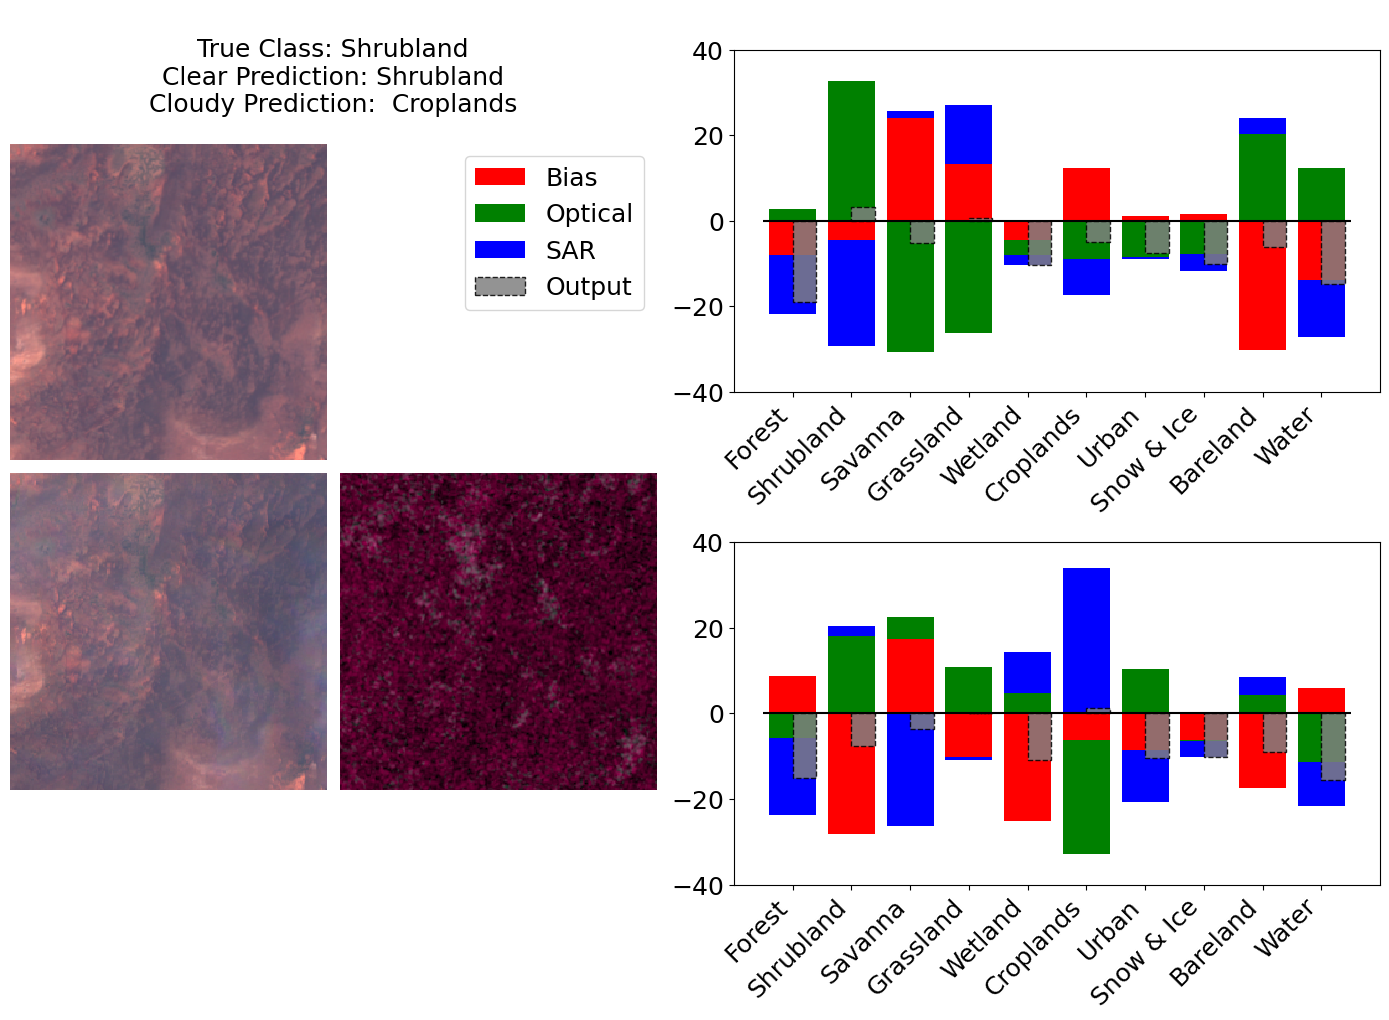

In [31]:
set_seed(42)

labels_str = ["Bias", "SAR", "Optical"]
ncols = 2
nrows = 100

plot_idx = torch.randperm(len(test_data))
plot_idx = [idx for idx in plot_idx if "s2_cloudy" in test_data.samples[idx] 
                                        and test_data.samples[idx]["s2_cloudy"] is not None 
                                        and test_data.labels_filtered[test_data.samples[idx]["id"]] != 2]
plot_idx = plot_idx[:ncols*nrows]

for sub_sample_id in plot_idx:

    s = test_data.samples[sub_sample_id]["id"]

    sample = test_data.get_print_data(sub_sample_id)
    sample_name = sample["id"]
    label = sample["label"]

    fig = plt.figure(figsize=(14,10))
    gs = GridSpec(2, 2, figure=fig, height_ratios=[0.5,0.5], width_ratios=[0.5,0.5])

    ax11 = fig.add_subplot(gs[0:2, 0])
    ax13 = fig.add_subplot(gs[0, 1])        
    ax23 = fig.add_subplot(gs[1, 1])       

    img_opt_clear = sample["img1_clear"]
    img_opt_cloudy = sample["img1_cloudy"]
    img_sar = sample["img2"]

    img = torch.cat([
        torch.cat([img_opt_clear, torch.ones([10, img_sar.shape[0],3]), img_opt_cloudy],0),
        torch.ones([img_sar.shape[0]*2 + 10, 10, 3]),
        torch.cat([torch.ones_like(img_sar), torch.ones([10, img_sar.shape[0],3]), img_sar],0)], 1)

    ax11.axis('off')
    ax11.matshow(img)
    
    pred_pos_clear = rfp_test_id_list_clear.index(sample_name)
    pred_pos_cloudy = rfp_test_id_list_cloudy.index(sample_name)

    text_size = 18
    ax13.bar(range(10), rfp_test_pred_list_clear[0,pred_pos_clear], label=labels_str[0], color='r')
    ax13.bar(range(10), rfp_test_pred_list_clear[1,pred_pos_clear].clip(min=0), width=0.8, bottom=rfp_test_pred_list_clear[:1,pred_pos_clear].clip(min=0).sum(0), label=labels_str[2], color='g')
    ax13.bar(range(10), rfp_test_pred_list_clear[1,pred_pos_clear].clip(max=0), width=0.8, bottom=rfp_test_pred_list_clear[:1,pred_pos_clear].clip(max=0).sum(0), color='g')
    ax13.bar(range(10), rfp_test_pred_list_clear[2,pred_pos_clear].clip(min=0), width=0.8, bottom=rfp_test_pred_list_clear[:2,pred_pos_clear].clip(min=0).sum(0), label=labels_str[1], color='b')
    ax13.bar(range(10), rfp_test_pred_list_clear[2,pred_pos_clear].clip(max=0), width=0.8, bottom=rfp_test_pred_list_clear[:2,pred_pos_clear].clip(max=0).sum(0), color='b')
    ax13.bar(torch.arange(10)+0.2, rfp_test_pred_list_clear[:3,pred_pos_clear].sum(0), label="Output", width=0.4, color='gray', alpha=0.85, linestyle="--", edgecolor="black")
    ax13.hlines(y=0,xmin=-0.5, xmax=9.5, color="black")

    ax13.set_ylim([-40,40]) 
    ax13.tick_params(axis='x', labelsize=text_size)
    ax13.tick_params(axis='y', labelsize=text_size)
    ax13.set_xticks(range(10), CLASS_NAMES, rotation=45, ha="right", fontsize=text_size)

    text_size = 18
    ax23.bar(range(10), rfp_test_pred_list_cloudy[0,pred_pos_cloudy], label=labels_str[0], color='r')
    ax23.bar(range(10), rfp_test_pred_list_cloudy[1,pred_pos_cloudy].clip(min=0), width=0.8, bottom=rfp_test_pred_list_cloudy[:1,pred_pos_cloudy].clip(min=0).sum(0), label=labels_str[2], color='g')
    ax23.bar(range(10), rfp_test_pred_list_cloudy[1,pred_pos_cloudy].clip(max=0), width=0.8, bottom=rfp_test_pred_list_cloudy[:1,pred_pos_cloudy].clip(max=0).sum(0), color='g')
    ax23.bar(range(10), rfp_test_pred_list_cloudy[2,pred_pos_cloudy].clip(min=0), width=0.8, bottom=rfp_test_pred_list_cloudy[:2,pred_pos_cloudy].clip(min=0).sum(0), label=labels_str[1], color='b')
    ax23.bar(range(10), rfp_test_pred_list_cloudy[2,pred_pos_cloudy].clip(max=0), width=0.8, bottom=rfp_test_pred_list_cloudy[:2,pred_pos_cloudy].clip(max=0).sum(0), color='b')
    ax23.bar(torch.arange(10)+0.2, rfp_test_pred_list_cloudy[:3,pred_pos_cloudy].sum(0), label="Output", width=0.4, color='gray', alpha=0.85, linestyle="--", edgecolor="black")
    ax23.hlines(y=0,xmin=-0.5, xmax=9.5, color="black")
    ax23.tick_params(axis='x', labelsize=text_size)
    ax23.tick_params(axis='y', labelsize=text_size)
    ax23.set_ylim([-40,40]) 
    ax23.set_xticks(range(10), CLASS_NAMES, rotation=45, ha="right", fontsize=text_size)

    ax11.axis('off')
    ax11.legend(*ax13.get_legend_handles_labels(), fontsize=text_size, loc="upper right")
    ax11.set_title(f"\nTrue Class: {CLASS_NAMES[label]}" + \
                f"\nClear Prediction: {CLASS_NAMES[rfp_test_pred_list_clear.sum(0)[pred_pos_clear].argmax(-1).item()]}" + \
                f"\nCloudy Prediction:  {CLASS_NAMES[rfp_test_pred_list_cloudy.sum(0)[pred_pos_cloudy].argmax(-1).item()]}",
                fontsize=text_size)
    plt.tight_layout()

    os.makedirs("SEN12MS_examples", exist_ok=True)
    plt.savefig(os.path.join("SEN12MS_examples", f"SEN12MS_examples_{pred_pos_clear}.pdf"))    
    plt.savefig(os.path.join("SEN12MS_examples", f"SEN12MS_examples_{pred_pos_clear}.png"), dpi=300)
    plt.close()